In [2]:
# Cella 1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader,  random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from io import BytesIO
from PIL import Image
import os
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import open3d as o3d
from math import log10
from typing import Union, Tuple, Dict

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Cella 2
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(6, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.dec3 = DoubleConv(512, 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        dec3 = self.dec3(torch.cat([self.up3(enc4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))
        
        return self.final_conv(dec1)


In [4]:
#Cella 3
class StereoDataset(Dataset):
    def __init__(self, data_path, transform=None, disp_transform=None):
        self.data_path = data_path
        self.transform = transform
        self.disp_transform = disp_transform
        self.is_zip = data_path.endswith('.zip')
        
        if self.is_zip:
            self.zip_data = zipfile.ZipFile(data_path)
            all_files = self.zip_data.namelist()
            
            print("Primi 20 file nel zip:")
            for file in all_files[:20]:
                print(file)
            print("..." if len(all_files) > 20 else "")
            
            self.main_folder = os.path.commonprefix(all_files)
            print(f"Cartella principale: {self.main_folder}")
            
            self.left_images = sorted([f for f in all_files if f.endswith('leftImg8bit.png')])
            self.right_images = sorted([f for f in all_files if f.endswith('rightImg8bit.png')])
            self.disparity_maps = sorted([f for f in all_files if f.endswith('_disparity.png')])
        else:
            all_files = os.listdir(data_path)
            self.left_images = sorted([f for f in all_files if f.endswith('leftImg8bit.png')])
            self.right_images = sorted([f for f in all_files if f.endswith('rightImg8bit.png')])
            self.disparity_maps = sorted([f for f in all_files if f.endswith('_disparity.png')])

        print(f"Numero di immagini sinistre: {len(self.left_images)}")
        print(f"Numero di immagini destre: {len(self.right_images)}")
        print(f"Numero di mappe di disparità: {len(self.disparity_maps)}")

        if len(self.left_images) == 0 or len(self.right_images) == 0 or len(self.disparity_maps) == 0:
            raise ValueError("Non sono state trovate immagini. Verifica i nomi dei file.")

        if len(self.left_images) != len(self.right_images) or len(self.left_images) != len(self.disparity_maps):
            raise ValueError("Mancata corrispondenza nel numero di immagini sinistre, destre e mappe di disparità")

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        if self.is_zip:
            left_img = Image.open(BytesIO(self.zip_data.read(self.left_images[idx]))).convert('RGB')
            right_img = Image.open(BytesIO(self.zip_data.read(self.right_images[idx]))).convert('RGB')
            disparity = Image.open(BytesIO(self.zip_data.read(self.disparity_maps[idx])))
        else:
            left_img = Image.open(os.path.join(self.data_path, self.left_images[idx])).convert('RGB')
            right_img = Image.open(os.path.join(self.data_path, self.right_images[idx])).convert('RGB')
            disparity = Image.open(os.path.join(self.data_path, self.disparity_maps[idx]))

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
        
        if self.disp_transform:
            disparity = self.disp_transform(disparity)
        else:
            disparity = transforms.ToTensor()(np.array(disparity).astype(np.float32) / 256.0)

        # Data augmentation: random left-right flip
        if torch.rand(1) > 0.5:
            left_img, right_img = right_img, left_img
            disparity = torch.flip(disparity, [2])  # Flip horizontally

        return torch.cat((left_img, right_img), dim=0), disparity

# Codice per testare il dataset
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

disp_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = StereoDataset('C:/Users/Tesisti/testvisione/test.zip', transform=img_transform, disp_transform=disp_transform)
print(f"\nNumero totale di campioni: {len(dataset)}")

if len(dataset) > 0:
    first_item = dataset[0]
    print(f"Forma del primo elemento: {first_item[0].shape}, {first_item[1].shape}")
    print(f"Range dei valori - Immagini: [{first_item[0].min():.2f}, {first_item[0].max():.2f}], Disparità: [{first_item[1].min():.2f}, {first_item[1].max():.2f}]")
else:
    print("Il dataset è vuoto!")

# Prova a creare il DataLoader
try:
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
    print("DataLoader creato con successo.")
    
    # Test del DataLoader
    for batch in dataloader:
        images, disparities = batch
        print(f"Batch shape - Immagini: {images.shape}, Disparità: {disparities.shape}")
        break
except Exception as e:
    print(f"Errore nella creazione o nell'uso del DataLoader: {e}")

Primi 20 file nel zip:
visionetest/aachen_000000_000019_disparity.png
visionetest/aachen_000000_000019_leftImg8bit.png
visionetest/aachen_000000_000019_rightImg8bit.png
visionetest/aachen_000001_000019_disparity.png
visionetest/aachen_000001_000019_leftImg8bit.png
visionetest/aachen_000001_000019_rightImg8bit.png
visionetest/aachen_000002_000019_disparity.png
visionetest/aachen_000002_000019_leftImg8bit.png
visionetest/aachen_000002_000019_rightImg8bit.png
visionetest/aachen_000003_000019_disparity.png
visionetest/aachen_000003_000019_leftImg8bit.png
visionetest/aachen_000003_000019_rightImg8bit.png
visionetest/aachen_000004_000019_disparity.png
visionetest/aachen_000004_000019_leftImg8bit.png
visionetest/aachen_000004_000019_rightImg8bit.png
visionetest/aachen_000005_000019_disparity.png
visionetest/aachen_000005_000019_leftImg8bit.png
visionetest/aachen_000005_000019_rightImg8bit.png
visionetest/aachen_000006_000019_disparity.png
visionetest/aachen_000006_000019_leftImg8bit.png
...
C

Primi 20 file nel zip:
visionetest/aachen_000000_000019_disparity.png
visionetest/aachen_000000_000019_leftImg8bit.png
visionetest/aachen_000000_000019_rightImg8bit.png
visionetest/aachen_000001_000019_disparity.png
visionetest/aachen_000001_000019_leftImg8bit.png
visionetest/aachen_000001_000019_rightImg8bit.png
visionetest/aachen_000002_000019_disparity.png
visionetest/aachen_000002_000019_leftImg8bit.png
visionetest/aachen_000002_000019_rightImg8bit.png
visionetest/aachen_000003_000019_disparity.png
visionetest/aachen_000003_000019_leftImg8bit.png
visionetest/aachen_000003_000019_rightImg8bit.png
visionetest/aachen_000004_000019_disparity.png
visionetest/aachen_000004_000019_leftImg8bit.png
visionetest/aachen_000004_000019_rightImg8bit.png
visionetest/aachen_000005_000019_disparity.png
visionetest/aachen_000005_000019_leftImg8bit.png
visionetest/aachen_000005_000019_rightImg8bit.png
visionetest/aachen_000006_000019_disparity.png
visionetest/aachen_000006_000019_leftImg8bit.png
...
C

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target validi.


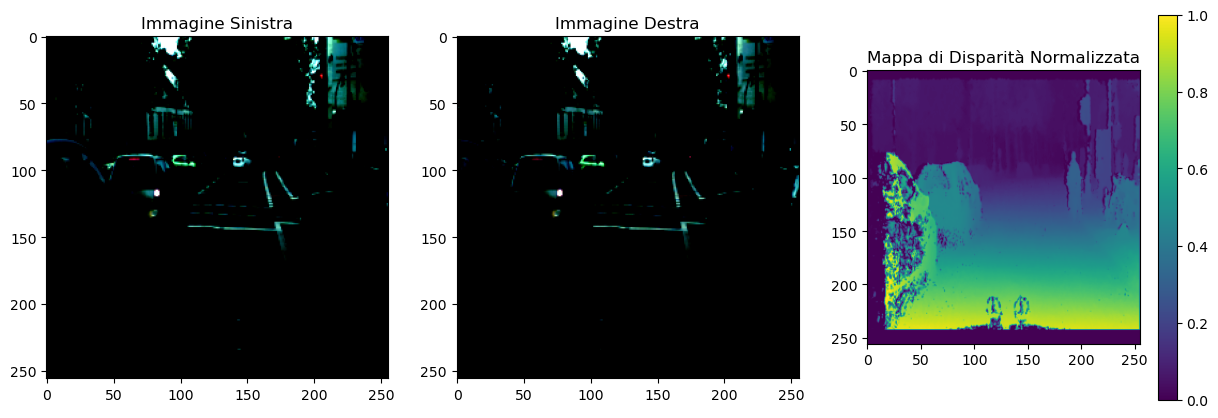

Images: torch.Size([8, 6, 256, 256]), Targets: torch.Size([8, 1, 256, 256])
Target range: 0.0000 to 1.0000


In [5]:
#Cella 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Trasformazioni separate per immagini e mappe di profondità
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

depth_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class NormalizedStereoDataset(StereoDataset):
    def __init__(self, data_path):
        super().__init__(data_path)
        self.image_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.disparity_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        if self.is_zip:
            left_img = Image.open(BytesIO(self.zip_data.read(self.left_images[idx])))
            right_img = Image.open(BytesIO(self.zip_data.read(self.right_images[idx])))
            disparity = Image.open(BytesIO(self.zip_data.read(self.disparity_maps[idx])))
        else:
            left_img = Image.open(os.path.join(self.data_path, self.left_images[idx]))
            right_img = Image.open(os.path.join(self.data_path, self.right_images[idx]))
            disparity = Image.open(os.path.join(self.data_path, self.disparity_maps[idx]))

        # Applica le trasformazioni
        left_img = self.image_transform(left_img)
        right_img = self.image_transform(right_img)
        disparity = self.disparity_transform(disparity)

        # Normalizza la mappa di disparità nell'intervallo [0, 1]
        disparity = (disparity - disparity.min()) / (disparity.max() - disparity.min() + 1e-8)

        # Combina le immagini sinistra e destra
        combined_img = torch.cat((left_img, right_img), dim=0)

        return combined_img, disparity

dataset = NormalizedStereoDataset('C:/Users/Tesisti/testvisione/test.zip')
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Verifica dei dati
data_iter = iter(dataloader)
images, targets = next(data_iter)

if torch.allclose(targets, torch.zeros_like(targets)):
    print("Attenzione: i target sono composti solo da zeri!")
else:
    print("Target validi.")

# Visualizzazione
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(images[0, :3].permute(1, 2, 0).cpu().numpy())
plt.title('Immagine Sinistra')
plt.subplot(1, 3, 2)
plt.imshow(images[0, 3:].permute(1, 2, 0).cpu().numpy())
plt.title('Immagine Destra')
plt.subplot(1, 3, 3)
plt.imshow(targets[0][0].cpu().numpy(), cmap='viridis')
plt.title('Mappa di Disparità Normalizzata')
plt.colorbar()
plt.show()

print(f"Images: {images.shape}, Targets: {targets.shape}")
print(f"Target range: {targets.min().item():.4f} to {targets.max().item():.4f}")

In [8]:
#Cella 5
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def save_image(img, path):
    """Salva l'immagine normalizzata."""
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='viridis')
    plt.colorbar()
    plt.savefig(path)
    plt.close()

# Configurazione
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001
val_ratio = 0.2
checkpoint_interval = 5

# Preparazione del dataset
dataset = NormalizedStereoDataset('C:/Users/Tesisti/testvisione/test.zip')
dataset_size = len(dataset)
val_size = int(val_ratio * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)

# Modello, ottimizzatore e scheduler
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Cartelle per i salvataggi
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
            
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    # Aggiorna lo scheduler
    scheduler.step(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Salvataggio del miglior modello
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'checkpoints/best_model.pth')
        print(f"Miglior modello salvato con validation loss: {best_val_loss:.4f}")
    
    # Checkpoint regolare
    if (epoch + 1) % checkpoint_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')
    
    # Visualizzazione e salvataggio di un esempio
    sample_data, sample_target = next(iter(val_loader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    sample_output = model(sample_data)
    
    save_image(denormalize(sample_data[0, :3]).cpu().permute(1,2,0).numpy(), f'visualizations/epoch_{epoch+1}_left_input.png')
    save_image(denormalize(sample_data[0, 3:]).cpu().permute(1,2,0).numpy(), f'visualizations/epoch_{epoch+1}_right_input.png')
    save_image(sample_target[0, 0].cpu().numpy(), f'visualizations/epoch_{epoch+1}_target.png')
    save_image(sample_output[0, 0].detach().cpu().numpy(), f'visualizations/epoch_{epoch+1}_output.png')

print("Training completed!")


C:\Users\Tesisti\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Primi 20 file nel zip:
visionetest/aachen_000000_000019_disparity.png
visionetest/aachen_000000_000019_leftImg8bit.png
visionetest/aachen_000000_000019_rightImg8bit.png
visionetest/aachen_000001_000019_disparity.png
visionetest/aachen_000001_000019_leftImg8bit.png
visionetest/aachen_000001_000019_rightImg8bit.png
visionetest/aachen_000002_000019_disparity.png
visionetest/aachen_000002_000019_leftImg8bit.png
visionetest/aachen_000002_000019_rightImg8bit.png
visionetest/aachen_000003_000019_disparity.png
visionetest/aachen_000003_000019_leftImg8bit.png
visionetest/aachen_000003_000019_rightImg8bit.png
visionetest/aachen_000004_000019_disparity.png
visionetest/aachen_000004_000019_leftImg8bit.png
visionetest/aachen_000004_000019_rightImg8bit.png
visionetest/aachen_000005_000019_disparity.png
visionetest/aachen_000005_000019_leftImg8bit.png
visionetest/aachen_000005_000019_rightImg8bit.png
visionetest/aachen_000006_000019_disparity.png
visionetest/aachen_000006_000019_leftImg8bit.png
...
C

Epoch 1/10: 100%|████████████████████████████████████████████████████████| 5/5 [01:21<00:00, 16.21s/batch, loss=0.0933]


Epoch 1/10, Train Loss: 0.4112, Val Loss: 0.1082
Miglior modello salvato con validation loss: 0.1082


Epoch 2/10: 100%|█████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.42s/batch, loss=0.053]


Epoch 2/10, Train Loss: 0.0609, Val Loss: 0.0807
Miglior modello salvato con validation loss: 0.0807


Epoch 3/10: 100%|████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.47s/batch, loss=0.0395]


Epoch 3/10, Train Loss: 0.0411, Val Loss: 0.4000


Epoch 4/10: 100%|████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.93s/batch, loss=0.0259]


Epoch 4/10, Train Loss: 0.0283, Val Loss: 3.5079


Epoch 5/10: 100%|████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.87s/batch, loss=0.0218]


Epoch 5/10, Train Loss: 0.0232, Val Loss: 0.9175


Epoch 6/10: 100%|████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.75s/batch, loss=0.0162]


Epoch 6/10, Train Loss: 0.0188, Val Loss: 0.6835


Epoch 7/10: 100%|█████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/batch, loss=0.015]


Epoch 7/10, Train Loss: 0.0164, Val Loss: 0.0689
Miglior modello salvato con validation loss: 0.0689


Epoch 8/10: 100%|████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.64s/batch, loss=0.0154]


Epoch 8/10, Train Loss: 0.0148, Val Loss: 0.0761


Epoch 9/10: 100%|████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.74s/batch, loss=0.0146]


Epoch 9/10, Train Loss: 0.0139, Val Loss: 0.0412
Miglior modello salvato con validation loss: 0.0412


Epoch 10/10: 100%|███████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.87s/batch, loss=0.0106]


Epoch 10/10, Train Loss: 0.0126, Val Loss: 0.0249
Miglior modello salvato con validation loss: 0.0249
Training completed!


In [6]:
#Cella 6
def block_matching(left_img, right_img, max_disparity=64, block_size=9):
    h, w = left_img.shape[:2]
    disparity_map = np.zeros((h, w), dtype=np.float32)
    
    for y in range(block_size // 2, h - block_size // 2):
        for x in range(block_size // 2, w - block_size // 2):
            left_block = left_img[y - block_size // 2 : y + block_size // 2 + 1,
                                  x - block_size // 2 : x + block_size // 2 + 1]
            
            best_match = float('inf')
            best_disparity = 0
            
            for d in range(max_disparity):
                if x - d < block_size // 2:
                    continue
                
                right_block = right_img[y - block_size // 2 : y + block_size // 2 + 1,
                                        x - d - block_size // 2 : x - d + block_size // 2 + 1]
                
                diff = np.sum(np.abs(left_block - right_block))
                
                if diff < best_match:
                    best_match = diff
                    best_disparity = d
            
            disparity_map[y, x] = best_disparity
    
    return disparity_map

def disparity_to_depth(disparity_map: np.ndarray, baseline: float, focal_length: float) -> np.ndarray:
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    mask = disparity_map > 0
    depth_map[mask] = (baseline * focal_length) / disparity_map[mask]
    return depth_map

def depth_to_pointcloud(depth_map: np.ndarray, intrinsics: tuple) -> np.ndarray:
    h, w = depth_map.shape
    fx, fy, cx, cy = intrinsics
    
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    x = (x - cx) * depth_map / fx
    y = (y - cy) * depth_map / fy
    
    xyz = np.stack((x, y, depth_map), axis=-1)
    return xyz.reshape(-1, 3)

def normalize_depth_maps(
    predicted_depth: Union[np.ndarray, torch.Tensor],
    real_depth: Union[np.ndarray, torch.Tensor],
    method: str = 'minmax'
) -> Tuple[np.ndarray, np.ndarray]:
    # Converti in numpy se necessario
    if torch.is_tensor(predicted_depth):
        predicted_depth = predicted_depth.detach().cpu().numpy()
    if torch.is_tensor(real_depth):
        real_depth = real_depth.detach().cpu().numpy()
    
    if method == 'minmax':
        # Normalizza nell'intervallo [0,1]
        pred_norm = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())
        real_norm = (real_depth - real_depth.min()) / (real_depth.max() - real_depth.min())
    
    elif method == 'scale_match':
        # Scala la predizione per matchare il range del ground truth
        scale = real_depth.max() / predicted_depth.max()
        pred_norm = predicted_depth * scale
        real_norm = real_depth
    
    elif method == 'zscore':
        # Standardizzazione Z-score
        pred_norm = (predicted_depth - predicted_depth.mean()) / predicted_depth.std()
        real_norm = (real_depth - real_depth.mean()) / real_depth.std()
    
    return pred_norm, real_norm

def calculate_depth_metrics(
    predicted_depth: Union[np.ndarray, torch.Tensor],
    real_depth: Union[np.ndarray, torch.Tensor],
    normalize: bool = True,
    normalization_method: str = 'scale_match'
) -> Dict[str, float]:
    
    # Normalizza se richiesto
    if normalize:
        predicted_depth, real_depth = normalize_depth_maps(
            predicted_depth, real_depth, method=normalization_method
        )
    
    # Calcola MSE e RMSE
    mse = np.mean((predicted_depth - real_depth) ** 2)
    rmse = np.sqrt(mse)
    
    # Calcola PSNR
    max_pixel = max(np.max(predicted_depth), np.max(real_depth))
    psnr = 20 * np.log10(max_pixel / (np.sqrt(mse)))
    
    return {
        'MSE': float(mse),
        'RMSE': float(rmse),
        'PSNR': float(psnr)
    }



def disparity_to_pointcloud(disparity_map, baseline, focal_length, intrinsics):
    h, w = disparity_map.shape
    fx, fy, cx, cy = intrinsics
    
    # Genera una griglia di coordinate pixel
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Calcola la profondità dalla disparità
    depth_map = disparity_to_depth(disparity_map, baseline, focal_length)
    
    # Rimuovi i valori non validi (NaN o infiniti) dalla mappa di profondità
    valid_mask = np.isfinite(depth_map)
    
    # Converti i pixel in coordinate 3D (X, Y, Z)
    X = (x - cx) * depth_map / fx
    Y = (y - cy) * depth_map / fy
    Z = depth_map
    
    # Applica la maschera per considerare solo punti validi
    points = np.stack((X[valid_mask], Y[valid_mask], Z[valid_mask]), axis=-1)
    
    return points

def create_point_cloud(points, colors):
    point_cloud = o3d.geometry.PointCloud()

    # Imposta le coordinate dei punti
    point_cloud.points = o3d.utility.Vector3dVector(points)
    
    # Normalizza i colori tra 0 e 1, e applica la maschera per colori validi
    point_cloud.colors = o3d.utility.Vector3dVector(colors / 255.0)
    
    return point_cloud

def visualize_point_cloud(point_cloud):
    o3d.visualization.draw_geometries([point_cloud])

In [14]:
# Cella 7
model.load_state_dict(torch.load('C:/Users/Tesisti/best_model.pth', map_location=device))
model.eval()
with torch.no_grad():
    # Prendi un campione dal dataset
    sample_data, sample_target = next(iter(dataloader))
    sample_data, sample_target = sample_data.to(device), sample_target.to(device)
    
    # Predici la mappa di disparità
    predicted_disparity = model(sample_data)
    
    # Converti in numpy per il block matching e le successive operazioni
    left_np = sample_data[0, :3].cpu().permute(1, 2, 0).numpy()  # Immagine sinistra
    right_np = sample_data[0, 3:].cpu().permute(1, 2, 0).numpy()  # Immagine destra
    predicted_disparity_np = predicted_disparity[0, 0].cpu().numpy()  # Disparità predetta
    baseline = 0.1  # metri
    focal_length = 500  # pixel
    predicted_depth = disparity_to_depth(predicted_disparity_np, baseline, focal_length)
    target_disparity = sample_target[0, 0].cpu().numpy()
    depth_map = disparity_to_depth(target_disparity, baseline, focal_length)
    # Applica block matching (se necessario)
    refined_disparity = block_matching(left_np, right_np)
    
    # Calcola la point cloud
    intrinsics = (500, 500, 128, 128)  # Parametri della telecamera (fx, fy, cx, cy)
    points = disparity_to_pointcloud(refined_disparity, baseline, focal_length, intrinsics)
    
    # Ottieni i colori dall'immagine sinistra (RGB)
    valid_mask = np.isfinite(depth_map).reshape(-1)  # Maschera dei punti validi
    colors = left_np.reshape(-1, 3)[valid_mask]  # Colori dei punti validi
    
    # Crea e visualizza la point cloud
    point_cloud = create_point_cloud(points, colors)
    visualize_point_cloud(point_cloud)
    
    # Prova diversi metodi di normalizzazione
    metrics_minmax = calculate_depth_metrics(predicted_depth, depth_map, 
                                       normalize=True, 
                                       normalization_method='minmax')
    

    print("\nMetriche con normalizzazione MinMax:")
    print(metrics_minmax)

C:\Users\Tesisti\AppData\Local\Temp\ipykernel_8132\2043846480.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/Tesisti/best_mod


Metriche con normalizzazione MinMax:
{'MSE': 0.007918331772089005, 'RMSE': 0.08898501098155975, 'PSNR': 21.013662815093994}


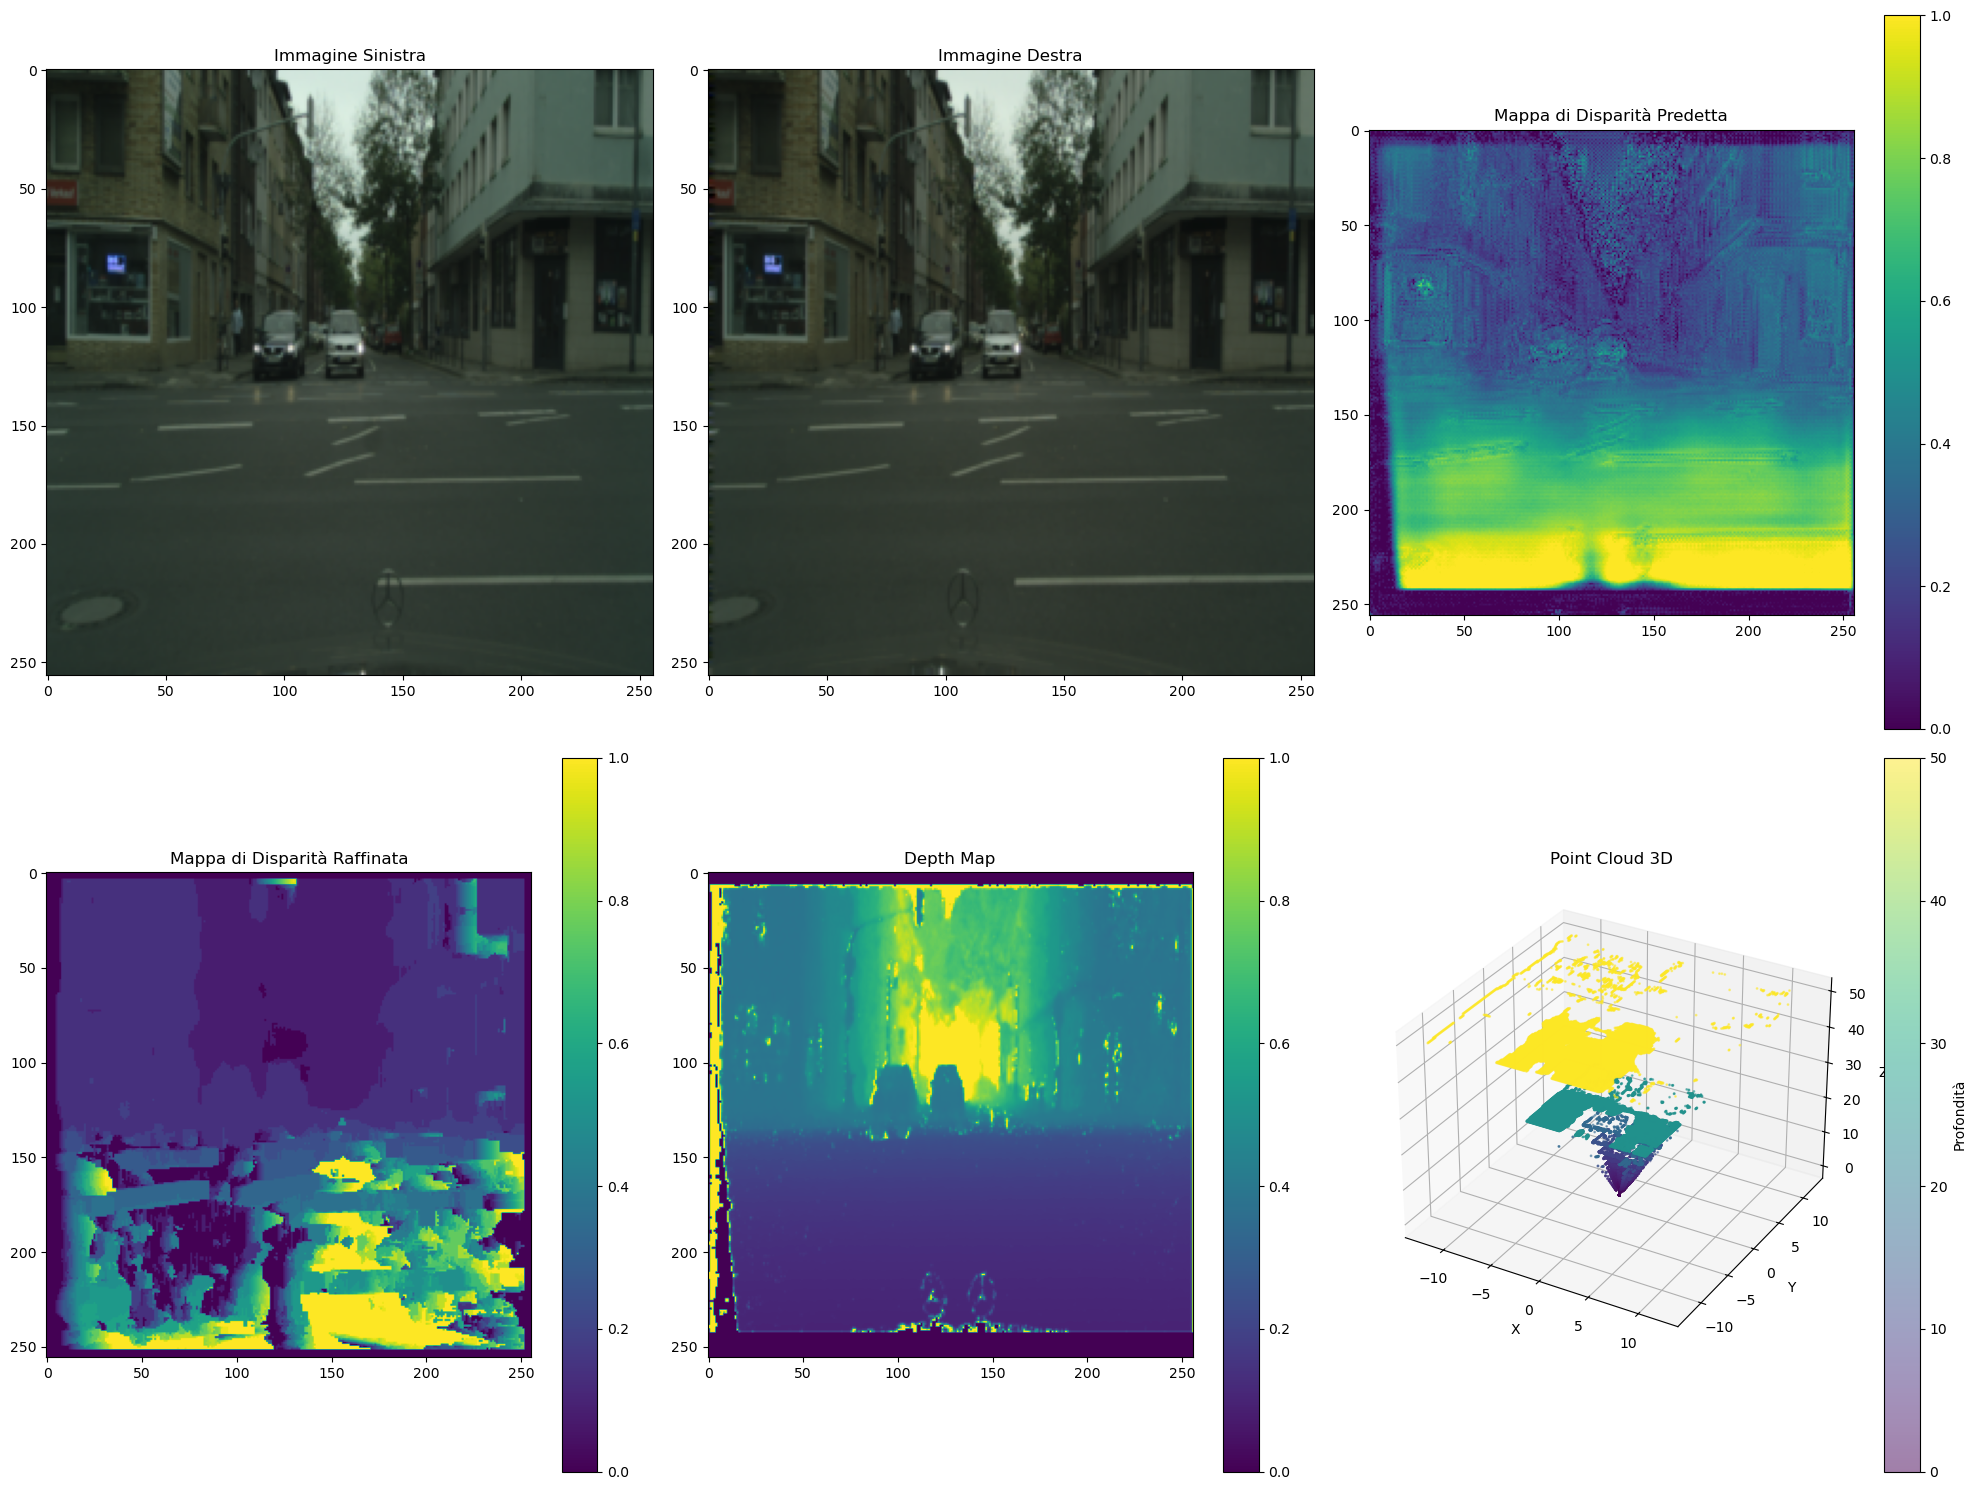

In [53]:
# Cella 8
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.permute(1, 2, 0).cpu().numpy()
    return np.clip(tensor * std + mean, 0, 1)

def enhance_depth_map(depth_map):
    # Copia per evitare modifiche all'originale
    depth = depth_map.copy()
    
    # Gestione outliers (opzionale)
    p1, p99 = np.percentile(depth[~np.isnan(depth)], (5, 95))
    depth = np.clip(depth, p1, p99)
    
    # Normalizzazione
    min_val = np.nanmin(depth)
    max_val = np.nanmax(depth)
    normalized = (depth - min_val) / (max_val - min_val + 1e-8)
    
    # Opzionale: aumenta il contrasto
    enhanced = np.power(normalized, 0.8)  # puoi modificare questo valore
    
    return enhanced

fig = plt.figure(figsize=(20, 15))

# Immagine Sinistra
ax1 = fig.add_subplot(231)
left_np = denormalize(sample_data[0, :3])
ax1.imshow(left_np)
ax1.set_title('Immagine Sinistra')

# Immagine Destra
ax2 = fig.add_subplot(232)
right_np = denormalize(sample_data[0, 3:])
ax2.imshow(right_np)
ax2.set_title('Immagine Destra')

# Mappa di Disparità Predetta
ax3 = fig.add_subplot(233)
enhanced_predicted_disparity = enhance_depth_map(predicted_disparity_np)
im3 = ax3.imshow(enhanced_predicted_disparity, cmap='viridis')
ax3.set_title('Mappa di Disparità Predetta')
plt.colorbar(im3, ax=ax3)

# Mappa di Disparità Raffinata
ax4 = fig.add_subplot(234)
enhanced_refined_disparity = enhance_depth_map(refined_disparity)
im4 = ax4.imshow(enhanced_refined_disparity, cmap='viridis')
ax4.set_title('Mappa di Disparità Raffinata')
plt.colorbar(im4, ax=ax4)

# Depth Map
ax5 = fig.add_subplot(235)
enhanced_depth_map = enhance_depth_map(depth_map)
im5 = ax5.imshow(enhanced_depth_map, cmap='viridis')
ax5.set_title('Depth Map')
plt.colorbar(im5, ax=ax5)

# Point Cloud 3D
ax6 = fig.add_subplot(236, projection='3d')

# Estrai i punti dall'oggetto Open3D PointCloud
points = np.asarray(point_cloud.points)

scatter = ax6.scatter(points[:, 0], points[:, 1], points[:, 2],
                      c=points[:, 2], cmap='viridis', s=1, alpha=0.5)
ax6.set_title('Point Cloud 3D')
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_zlabel('Z')
plt.colorbar(scatter, ax=ax6, label='Profondità')
plt.savefig('PointCloud.png')

# Imposta gli assi della point cloud per una migliore visualizzazione
ax6.auto_scale_xyz(points[:, 0], points[:, 1], points[:, 2])

plt.tight_layout()
plt.show()

In [47]:
# Cella 9
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.permute(1, 2, 0).cpu().numpy()
    return np.clip(tensor * std + mean, 0, 1)

# Funzione per visualizzare i risultati
def visualize_results(left_img, right_img, predicted_disparity, target_disparity):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    axs[0, 0].imshow(denormalize(left_img))
    axs[0, 0].set_title('Immagine Sinistra')
    
    axs[0, 1].imshow(denormalize(right_img))
    axs[0, 1].set_title('Immagine Destra')
    
    axs[1, 0].imshow(predicted_disparity, cmap='viridis')
    axs[1, 0].set_title('Mappa di Disparità Predetta')
    
    axs[1, 1].imshow(target_disparity, cmap='viridis')
    axs[1, 1].set_title('Mappa di Disparità Reale')
    
    plt.show()

# Definizione della classe TestDataset
class TestDataset(Dataset):
    def __init__(self, data_path, transform=None, disp_transform=None):
        self.data_path = data_path
        self.transform = transform
        self.disp_transform = disp_transform
        self.is_zip = data_path.endswith('.zip')
        
        if self.is_zip:
            self.zip_data = zipfile.ZipFile(data_path)
            all_files = self.zip_data.namelist()
            
            self.left_images = sorted([f for f in all_files if f.endswith('leftImg8bit.png')])
            self.right_images = sorted([f for f in all_files if f.endswith('rightImg8bit.png')])
            self.disparity_maps = sorted([f for f in all_files if f.endswith('_disparity.png')])
        else:
            raise ValueError("Only ZIP files are supported for now.")

        if len(self.left_images) == 0 or len(self.right_images) == 0 or len(self.disparity_maps) == 0:
            raise ValueError("Non sono state trovate immagini. Verifica i nomi dei file.")

        if len(self.left_images) != len(self.right_images) or len(self.left_images) != len(self.disparity_maps):
            raise ValueError("Mancata corrispondenza nel numero di immagini sinistre, destre e mappe di disparità")

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        if self.is_zip:
            left_img = Image.open(BytesIO(self.zip_data.read(self.left_images[idx]))).convert('RGB')
            right_img = Image.open(BytesIO(self.zip_data.read(self.right_images[idx]))).convert('RGB')
            disparity = Image.open(BytesIO(self.zip_data.read(self.disparity_maps[idx])))
        else:
            raise ValueError("Only ZIP files are supported for now.")

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
        
        if self.disp_transform:
            disparity = self.disp_transform(disparity)
        else:
            disparity = transforms.ToTensor()(np.array(disparity).astype(np.float32) / 256.0)

        # Data augmentation: random left-right flip
        if torch.rand(1) > 0.5:
            left_img, right_img = right_img, left_img
            disparity = torch.flip(disparity, [2])  # Flip horizontally

        return torch.cat((left_img, right_img), dim=0), disparity

# Funzione per preparare i dati di test
def prepare_test_data(data_path, transform=None, disp_transform=None, batch_size=1, num_workers=0):  # Disabilita il multiprocessing
    test_dataset = TestDataset(data_path, transform=transform, disp_transform=disp_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return test_loader

# Preparazione del dataset di test
test_loader = prepare_test_data('C:/Users/Tesisti/testvisione/test.zip', transform=img_transform, disp_transform=disp_transform)

C:\Users\Tesisti\AppData\Local\Temp\ipykernel_8132\1633079223.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/Tesisti/best_mod

Metriche:
{'MSE': 0.025913615884881704, 'RMSE': 0.16097706633207634, 'PSNR': 15.864719830278629}


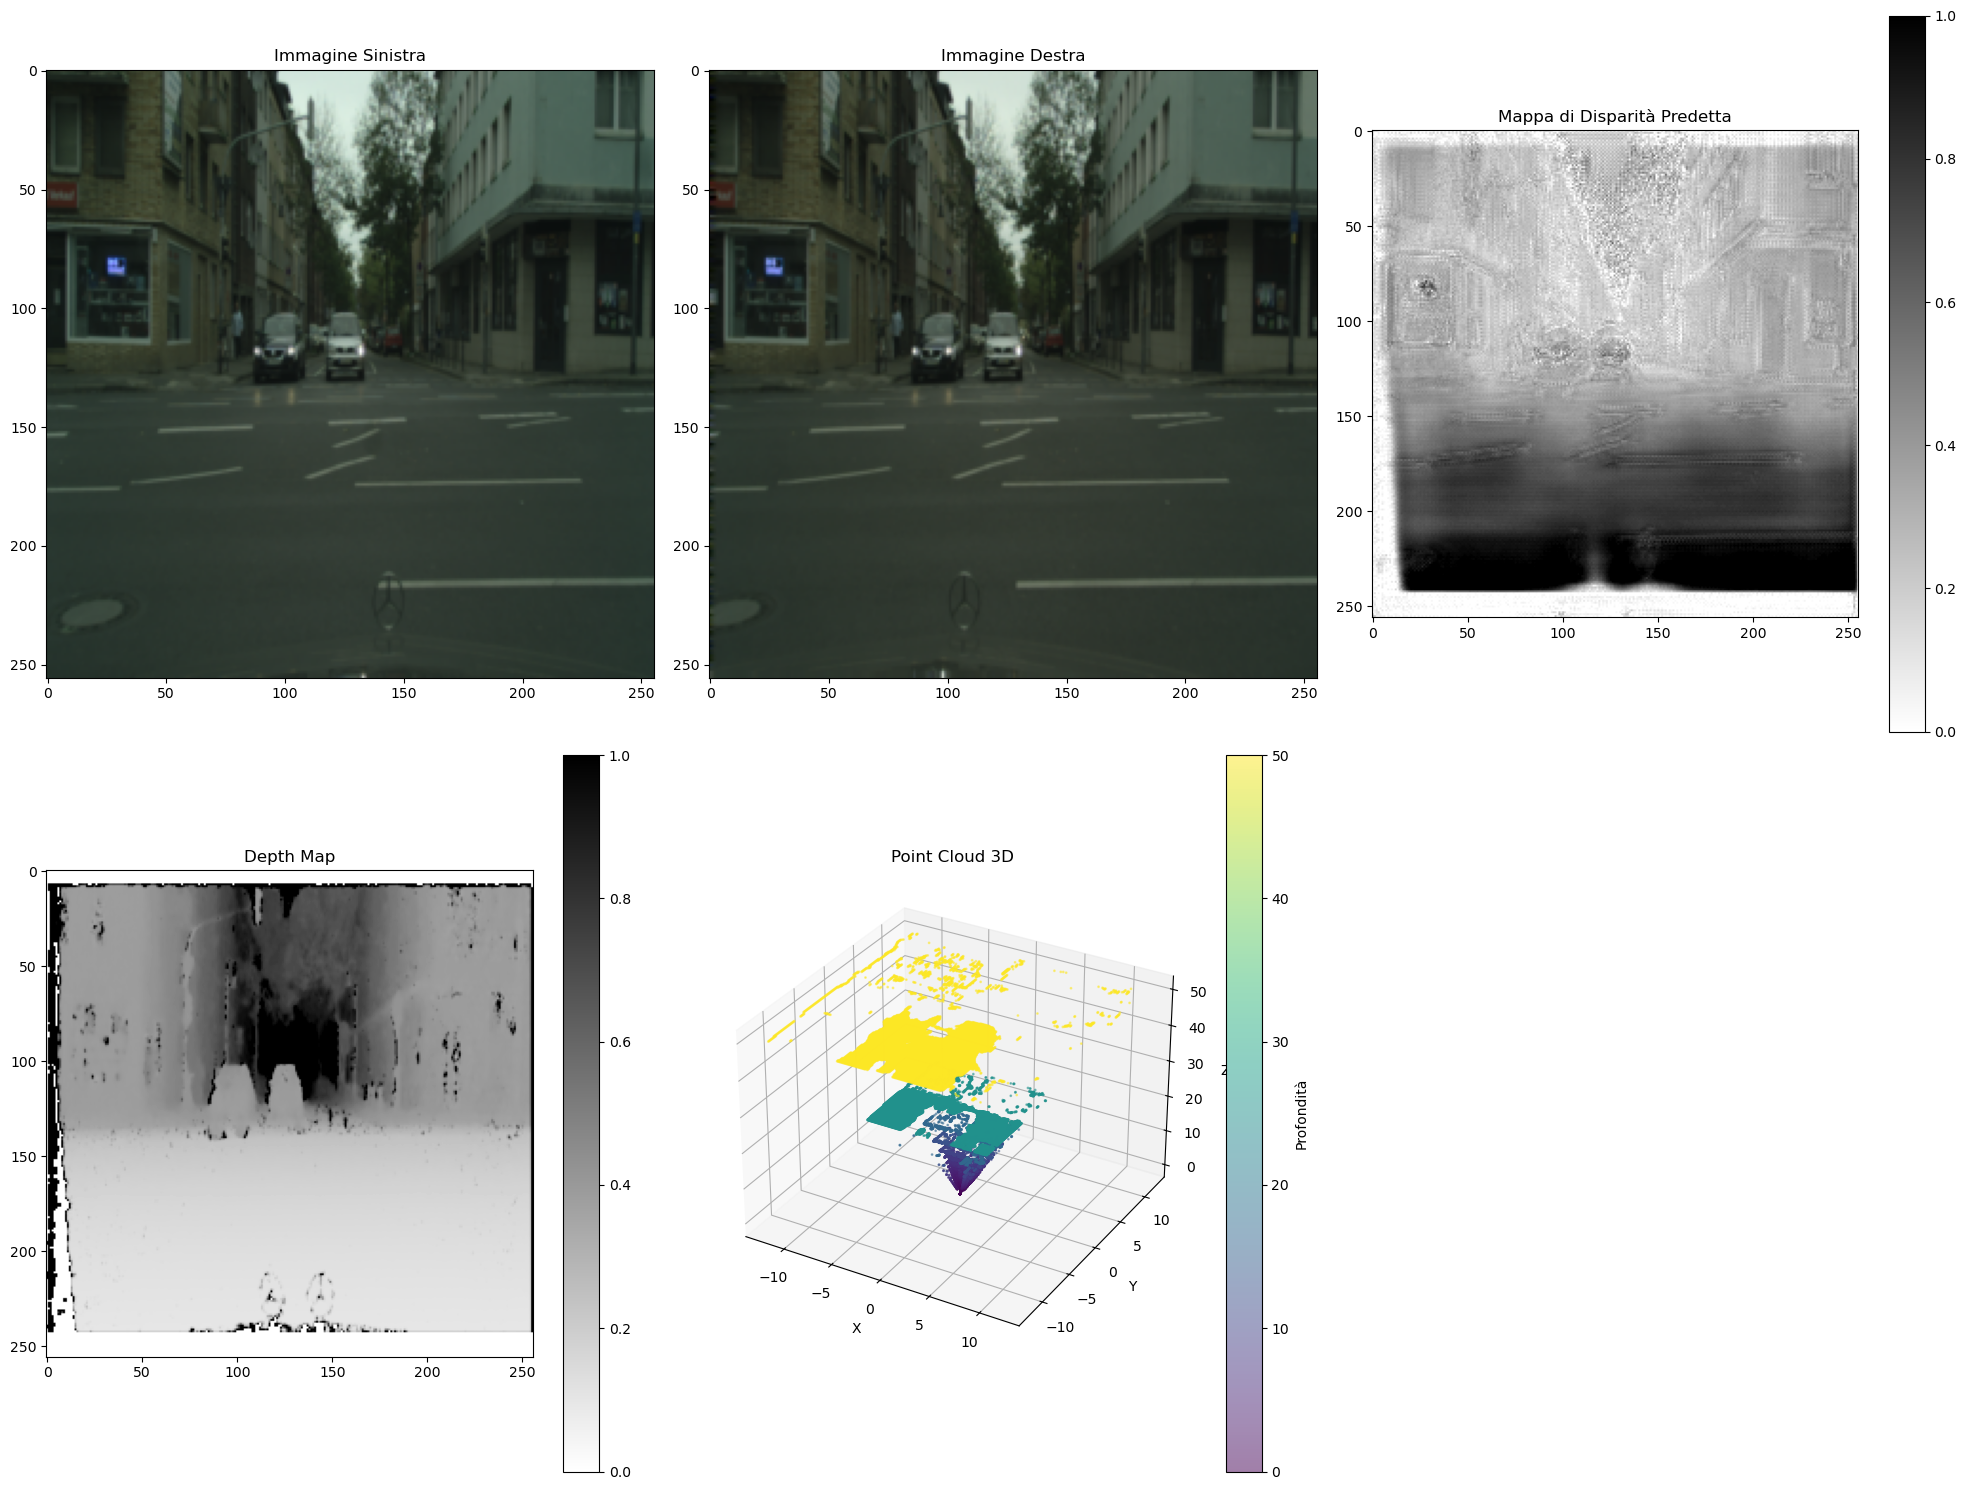

In [48]:
# Cella 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

# Carica il modello addestrato
model.load_state_dict(torch.load('C:/Users/Tesisti/best_model.pth', map_location=device))
model.eval()

with torch.no_grad():
    for batch in test_loader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device)
        
        # Predizione
        outputs = model(images)
        
        # Denormalizzazione delle immagini
        left_img = images[0, :3]
        right_img = images[0, 3:]
        predicted_disparity = outputs[0, 0].cpu().numpy()
        target_disparity = targets[0, 0].cpu().numpy()
        
        # Calcolo delle metriche
        metrics = calculate_depth_metrics(predicted_disparity, target_disparity, normalize=True, normalization_method='minmax')
        print("Metriche:")
        print(metrics)
        
        # Calcolo della depth map
        baseline = 0.1  # metri
        focal_length = 500  # pixel
        intrinsics = (500, 500, 128, 128)  # Parametri della telecamera (fx, fy, cx, cy)
        
        predicted_depth = disparity_to_depth(predicted_disparity, baseline, focal_length)
        target_depth = disparity_to_depth(target_disparity, baseline, focal_length)
        
        # Calcolo della point cloud dalla depth map
        predicted_points = disparity_to_pointcloud(predicted_disparity, baseline, focal_length, intrinsics)
        target_points = disparity_to_pointcloud(target_disparity, baseline, focal_length, intrinsics)
        
        # Ottieni i colori dall'immagine sinistra (RGB)
        left_np = denormalize(left_img).reshape(-1, 3)
        valid_mask = np.isfinite(predicted_depth).reshape(-1)
        colors = left_np[valid_mask]
        
        # Crea e visualizza la point cloud
        predicted_point_cloud = create_point_cloud(predicted_points, colors)
        
        # Cella 7: Visualizzazione dei risultati
        fig = plt.figure(figsize=(20, 15))

        # Immagine Sinistra
        ax1 = fig.add_subplot(231)
        left_np = denormalize(sample_data[0, :3])
        ax1.imshow(left_np)
        ax1.set_title('Immagine Sinistra')

        # Immagine Destra
        ax2 = fig.add_subplot(232)
        right_np = denormalize(sample_data[0, 3:])
        ax2.imshow(right_np)
        ax2.set_title('Immagine Destra')

        # Mappa di Disparità Predetta
        ax3 = fig.add_subplot(233)
        enhanced_predicted_disparity = enhance_depth_map(predicted_disparity_np)
        im3 = ax3.imshow(enhanced_predicted_disparity, cmap='gray_r')
        ax3.set_title('Mappa di Disparità Predetta')
        plt.colorbar(im3, ax=ax3)
        
        # Depth Map
        ax5 = fig.add_subplot(234)
        enhanced_depth_map = enhance_depth_map(depth_map)
        im5 = ax5.imshow(enhanced_depth_map, cmap='gray_r')
        ax5.set_title('Depth Map')
        plt.colorbar(im5, ax=ax5)

        # Point Cloud 3D
        ax6 = fig.add_subplot(235, projection='3d')

        # Estrai i punti dall'oggetto Open3D PointCloud
        points = np.asarray(point_cloud.points)

        scatter = ax6.scatter(points[:, 0], points[:, 1], points[:, 2],
                                  c=points[:, 2], cmap='viridis', s=1, alpha=0.5)
        ax6.set_title('Point Cloud 3D')
        ax6.set_xlabel('X')
        ax6.set_ylabel('Y')
        ax6.set_zlabel('Z')
        plt.colorbar(scatter, ax=ax6, label='Profondità')

        # Imposta gli assi della point cloud per una migliore visualizzazione
        ax6.auto_scale_xyz(points[:, 0], points[:, 1], points[:, 2])

        plt.tight_layout()
        plt.show()

        break  # Visualizza solo il primo batch per esempio